In [1]:
%config IPCompleter.greedy=True

In [2]:
import os

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import cloudpickle

In [5]:
from ase.build import bulk
from ase.calculators.espresso import Espresso
from ase.io import write
from pwtools import io

# Functions

In [6]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'input.pwi')
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data={
            'calculation': input_dict["calculation"],
            'occupations': 'smearing',
            'degauss': input_dict["smearing"],
        }, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [7]:
def collect_output(working_directory="."):
    filename = os.path.join(working_directory, 'output.pwo')
    try:
        return {"structure": io.read_pw_md(filename)[-1].get_ase_atoms()}
    except TypeError:
        out = io.read_pw_scf(filename)
        return {
            "energy": out.etot,
            "volume": out.volume,
        }

In [8]:
def workflow(project, structure): 
    # Structure optimization 
    job_qe_minimize = pr.create.job.QEJob(job_name="qe_relax")
    job_qe_minimize.input["calculation"] = "vc-relax"
    job_qe_minimize.input.structure = structure
    job_qe_minimize.run()
    structure_opt = job_qe_minimize.output.structure

    # Energy Volume Curve 
    energy_lst, volume_lst = [], []
    for i, strain in enumerate(np.linspace(0.9, 1.1, 5)):
        structure_strain = structure_opt.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain**(1/3), 
            scale_atoms=True
        )
        job_strain = pr.create.job.QEJob(
            job_name="job_strain_" + str(i)
        )
        job_strain.input.structure = structure_strain
        job_strain.run(delete_existing_job=True)
        energy_lst.append(job_strain.output.energy)
        volume_lst.append(job_strain.output.volume)
    
    return {"volume": volume_lst, "energy": energy_lst}

# Setup

In [9]:
from pyiron_base import Project

In [10]:
pr = Project("dft")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

In [11]:
pr.create_job_class(
    class_name="QEJob",
    write_input_funct=write_input,
    collect_output_funct=collect_output,
    default_input_dict={  # Default Parameter 
        "structure": None, 
        "pseudopotentials": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, 
        "kpts": (3, 3, 3),
        "calculation": "scf",
        "smearing": 0.02,
    },
    executable_str="mpirun -np 1 pw.x -in input.pwi > output.pwo",
)

# Workflow

In [12]:
job_workflow = pr.wrap_python_function(workflow)
job_workflow.input.project = pr
job_workflow.input.structure = bulk('Al', a=4.05, cubic=True)
job_workflow.run()

The job workflowed1e0e361baad58ba8357a7ef78b8d7f was saved and received the ID: 82
The job qe_relax was saved and received the ID: 83
The job job_strain_0 was saved and received the ID: 84
The job job_strain_1 was saved and received the ID: 85
The job job_strain_2 was saved and received the ID: 86
The job job_strain_3 was saved and received the ID: 87
The job job_strain_4 was saved and received the ID: 88


# Result

Text(0, 0.5, 'Energy')

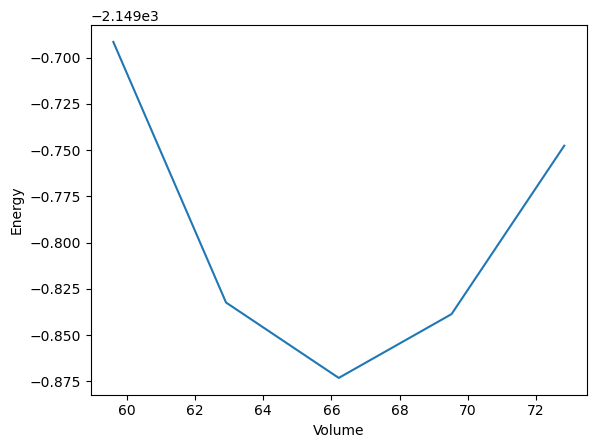

In [13]:
plt.plot(job_workflow.output.result["volume"], job_workflow.output.result["energy"])
plt.xlabel("Volume")
plt.ylabel("Energy")

# Summary

In [14]:
pr.job_table()

id    status chemicalformula                                       job  \
0  82  finished            None  workflowed1e0e361baad58ba8357a7ef78b8d7f   
1  83  finished            None                                  qe_relax   
2  84  finished            None                              job_strain_0   
3  85  finished            None                              job_strain_1   
4  86  finished            None                              job_strain_2   
5  87  finished            None                              job_strain_3   
6  88  finished            None                              job_strain_4   

                                      subjob    projectpath project  \
0  /workflowed1e0e361baad58ba8357a7ef78b8d7f  /home/jovyan/    dft/   
1                                  /qe_relax  /home/jovyan/    dft/   
2                              /job_strain_0  /home/jovyan/    dft/   
3                              /job_strain_1  /home/jovyan/    dft/   
4                              /job_strain_2  /home/jovyan/    dft/   
5                              /job_strain_3  /home/jovyan/    dft/   
6                              /job_strain_4  /home/jovyan/    dft/   

                   timestart                   timestop  totalcputime  \
0 2024-04-03 02:54:58.435729                        NaT           NaN   
1 2024-04-03 02:54:58.673799 2024-04-03 02:56:51.225130         112.0   
2 2024-04-03 02:56:51.341078 2024-04-03 02:57:11.970281          20.0   
3 2024-04-03 02:57:12.137787 2024-04-03 02:57:33.696009          21.0   
4 2024-04-03 02:57:33.823502 2024-04-03 02:58:01.182953          27.0   
5 2024-04-03 02:58:01.319806 2024-04-03 02:58:32.595498          31.0   
6 2024-04-03 02:58:32.736668 2024-04-03 02:59:02.482025          29.0   

                                                          computer  \
0  pyiron@jupyter-pyiron-2dworkshop-2dimsi-2dtutorial-2dhrtbbqxy#1   
1  pyiron@jupyter-pyiron-2dworkshop-2dimsi-2dtutorial-2dhrtbbqxy#1   
2  pyiron@jupyter-pyiron-2dworkshop-2dimsi-2dtutorial-2dhrtbbqxy#1   
3  pyiron@jupyter-pyiron-2dworkshop-2dimsi-2dtutorial-2dhrtbbqxy#1   
4  pyiron@jupyter-pyiron-2dworkshop-2dimsi-2dtutorial-2dhrtbbqxy#1   
5  pyiron@jupyter-pyiron-2dworkshop-2dimsi-2dtutorial-2dhrtbbqxy#1   
6  pyiron@jupyter-pyiron-2dworkshop-2dimsi-2dtutorial-2dhrtbbqxy#1   

                     hamilton hamversion parentid masterid  
0  PythonFunctionContainerJob        0.4     None     None  
1      ExecutableContainerJob        0.4     None     None  
2      ExecutableContainerJob        0.4     None     None  
3      ExecutableContainerJob        0.4     None     None  
4      ExecutableContainerJob        0.4     None     None  
5      ExecutableContainerJob        0.4     None     None  
6      ExecutableContainerJob        0.4     None     None